In [1]:
import numpy as np
import cupy as cp
import time
import random
import pylab
from hrr import *
%matplotlib inline
from matplotlib import pyplot as plt
from IPython.display import clear_output

np.random.seed(1)
random.seed(1)

In [2]:
# Number of training cycles
episodes = 50000

# Hrr parameters
hrr_length = 6144
normalized = True

# How many steps to take before quiting
steps_till_quit = 100

goals = [5, 10, 15]

# Maze parameters
size_of_maze = 20
non_obs_task_switch_rate = 500
num_non_obs_tasks = len(goals)

# Arguments for neural network
input_size = hrr_length
output_size = 1
discount = 0.7
alpha = 0.1

# Reward for temporal difference learning
reward_bad = -1
reward_good = 0

# Expolration rate
e_soft = 0.0001

# Threshold for non observable task switching
threshold_negative = -0.3
treshold_positive = 0.3

# Print frequency
p_freq = 1000

# Eligibility trace
eligibility = np.zeros(hrr_length)

# Eligibility trace rate
eli_lambda = 0.01

# Neural network
weights = hrr(hrr_length, normalized)
bias = 1

rand_on = 1

debug = False

In [3]:
def get_moves(state, size_of_maze):
    if(state == 0):
        return size_of_maze - 1, 1
    elif(state == size_of_maze - 1):
        return size_of_maze - 2, 0
    else:
        return state - 1, state + 1

In [4]:
def update_progress(progress, episode):
    bar_length = 50
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Episode {0}, Progress: [{1}] {2:.1f}%".format(episode, "=" * block + "." * (bar_length - block), progress * 100)
    print(text)

In [5]:
ltm = LTM(hrr_length, normalized)

In [6]:
ltm.print()

I [1. 0. 0. ... 0. 0. 0.]


In [7]:
def context_policy_negative(atr):
    return (atr + 1)%num_non_obs_tasks

def context_policy_positive(state):
    val = -9999
    temp = -9999
    for atr in range(0, num_non_obs_tasks):
        encode_str = build_hrr_string(state, atr)
        temp = cp.dot(weights, ltm.encode(encode_str)) + bias
        if temp > val:
            val = temp
            s_atr = atr
    return s_atr

def build_hrr_string(state, atr):
    return "State:" + str(state) + "*" + "Atr:" + str(atr)
    
def move_policy(moves, atr, rand_on):
    
    val = -9999
    temp = -9999
    
    for move in moves:
        if move == goal:
            encode_str = build_hrr_string(str(move) + "*rewardTkn", atr)
        else:
            encode_str = build_hrr_string(move, atr)
        temp = cp.dot(weights, ltm.encode(encode_str)) + bias
        if(debug):
            print("State {0} value {1}".format(move, temp))
        if temp > val:
            val = temp
            s_move = move
            
    # Random move
    if((np.random.random_sample() < e_soft) and (rand_on == 1)):
        if(debug):
            print("RANDOM MOVE")
        return (np.random.choice(moves), val, 1)
    
    return (s_move, val, 0)

def logmod(x):
    return np.sign(x)*np.log(abs(x)+1)

def get_opt_steps(start, goal, size_of_maze):
    opt = abs(goal - start)
    if opt > size_of_maze / 2:
        opt = size_of_maze - opt
    return opt

In [8]:
t0 = time.time()
non_obs = 0
opt_count = 0
current_atr = 0
debug2 = False
step_store = []

for x in range(episodes):
    
    # Starting state
    current_state = random.randint(0, size_of_maze - 1)
    start = current_state

    last_non_obs = non_obs
    if x%non_obs_task_switch_rate == 0:
        non_obs = (non_obs+1)%num_non_obs_tasks
    
    goal = goals[non_obs]
    
    steps = 0
    opt_steps = get_opt_steps(start, goal, size_of_maze)
    
    # Reset trace
    eligibility *= 0.0
    
    if x > ((episodes * 8) / 10) :
        debug2 = True
        rand_on = 0
        alpha = 0.01
    
    if(debug):
        print("Start state {0} with goal State {1} and atr {2} with task {3}".format(current_state, goal, current_atr, non_obs))

    episode_memory = []
    for y in range(steps_till_quit):
        # Goal reached
        if (current_state == goal):
            encode_str = build_hrr_string(str(current_state) + "*rewardTkn", current_atr)
            goal_hrr = ltm.encode(encode_str)
            goal_value = cp.dot(weights, goal_hrr) + bias  
            episode_memory += [[current_state, current_value, goal]]

            error = reward_good - goal_value
            eligibility *= eli_lambda
            eligibility = eligibility + goal_hrr
            weights = np.add(weights, (alpha * logmod(error) * eligibility))
            
            if(debug):
                print("In goal with value {0}".format(goal_value))
            
            break
            
        previous_state = current_state
        previous_atr = current_atr 
        
        encode_str = build_hrr_string(previous_state, previous_atr)
        previous_state_hrr = ltm.encode(encode_str)
        previous_value = cp.dot(weights, previous_state_hrr) + bias
        episode_memory += [[previous_state, previous_value, goal]]
        
        left, right = get_moves(previous_state, size_of_maze)
        move, max_value, random_move = move_policy([left, right], previous_atr, rand_on)
        steps += 1
        
        if random_move:
            eligibility *= 0.0
        
        if(debug):
            print("Moves {0}, taken {1}".format([left, right], move))
        
        current_state = move
        current_atr = current_atr
        
        if current_state == goal:
            encode_str = build_hrr_string(str(current_state) + "*rewardTkn", current_atr)
        else:
            encode_str = build_hrr_string(str(current_state), current_atr)
            
        current_state_hrr = ltm.encode(encode_str)
        current_value = cp.dot(weights, current_state_hrr) + bias
        
        sarsa_error = (reward_bad + discount * current_value) - previous_value
        eligibility *= eli_lambda
        eligibility = eligibility + previous_state_hrr
        if sarsa_error > treshold_positive:
            current_atr = context_policy_positive(current_state)
            weights = np.add(weights, (alpha * logmod(sarsa_error) * eligibility))
            eligibility *= 0.0
            steps = 0
            opt_steps = get_opt_steps(current_state, goal, size_of_maze)
            if(debug):
                print("Changed atr from {0} to {1}".format(previous_atr, current_atr))
        if sarsa_error < threshold_negative:
            current_atr = context_policy_negative(previous_atr)
            weights = np.add(weights, (alpha * logmod(sarsa_error) * eligibility))
            eligibility *= 0.0
            steps = 0
            opt_steps = get_opt_steps(current_state, goal, size_of_maze)
            if(debug):
                print("Changed atr from {0} to {1}".format(previous_atr, current_atr))
        weights = np.add(weights, (alpha * sarsa_error * eligibility))
        
        if(debug):
            input("Enter")
            
    if(debug):
        print("steps taken {}, opt steps {}".format(steps, opt_steps))
        input("Enter")
        
    if(debug2):
        step_store += [steps - opt_steps]
        
    update_progress(x / episodes, x)
    
update_progress(1, episodes)

Episode 50000, Progress: [==================================================] 100.0%


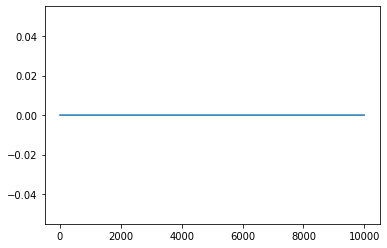

100.0


In [9]:
plt.plot(step_store)
plt.show()
accuracy = (len(step_store)-np.count_nonzero(step_store))*100.0 / len(step_store)
print(accuracy)

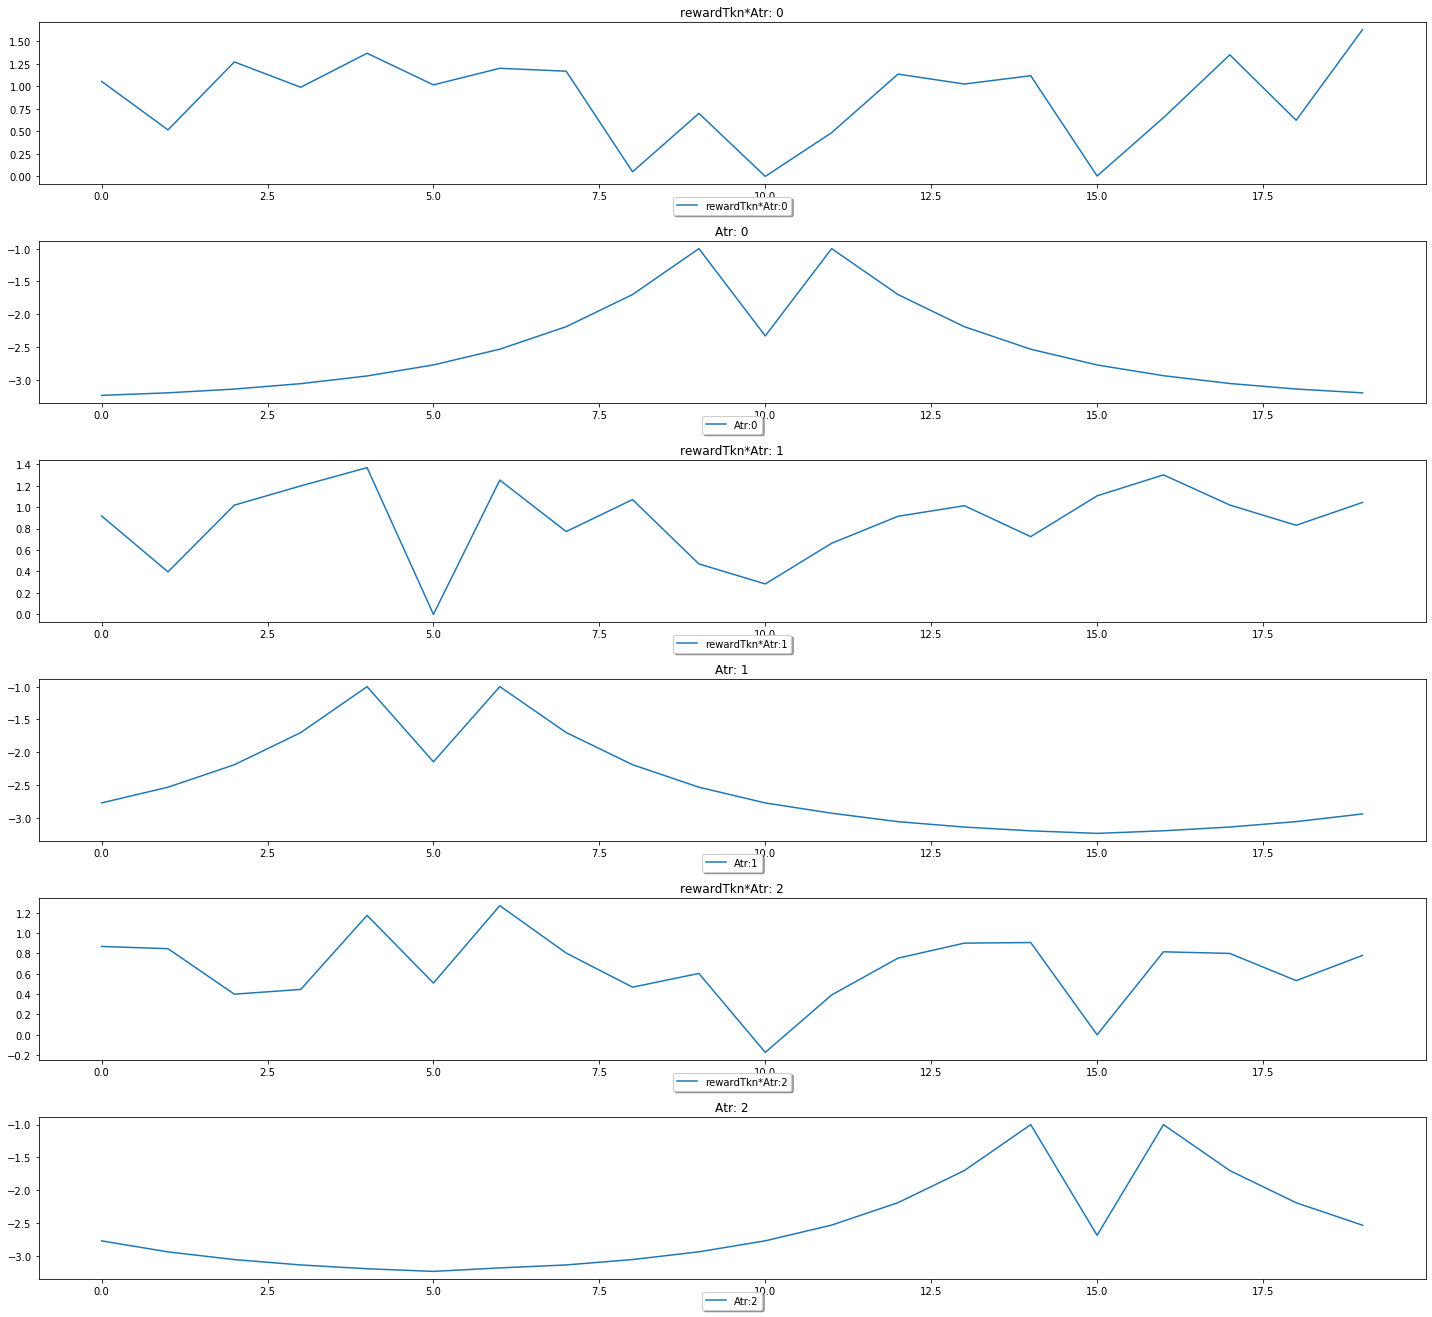

In [10]:
fig, axes = plt.subplots(nrows=num_non_obs_tasks * 2, ncols=1)
fig.set_figwidth(20)
fig.set_figheight(20)

for x in range(num_non_obs_tasks):
    
    x_ind = x * 2
    
    y_for_rwd = 0
    y_for_no_rwd = 0
    
    position = np.arange(size_of_maze)
    value = np.zeros(size_of_maze)
    lab = "rewardTkn*Atr:" + str(x)
    for state in range(size_of_maze):
        encode_str = build_hrr_string(str(state) + "*rewardTkn", x)
        value[state] = cp.dot(weights, ltm.encode(encode_str)) + bias
    axes[x_ind].title.set_text("rewardTkn*" + "Atr: " + str(x))
    axes[x_ind].plot(position, value, label=lab)
        
    axes[x_ind].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
                  fancybox=True, shadow=True, ncol=1, prop={'size': 10})
    
    
    y = x + 1
    
    position = np.arange(size_of_maze)
    value = np.zeros(size_of_maze)
    lab = "Atr:" + str(x)
    for state in range(size_of_maze):
        encode_str = build_hrr_string(str(state), x)
        value[state] = cp.dot(weights, ltm.encode(encode_str)) + bias
    axes[x_ind+1].title.set_text("Atr: " + str(x))
    axes[x_ind+1].plot(position, value, label=lab)
    
    axes[x_ind+1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
        fancybox=True, shadow=True, ncol=1, prop={'size': 10})
    y_for_no_rwd += 1
    
    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
t1 = time.time()

In [11]:
total = t1-t0
print(total / 60)

1.7995079716046651


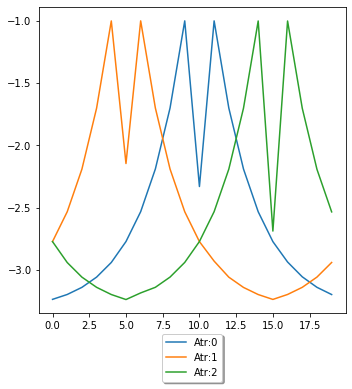

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=1)
fig.set_figwidth(5)
fig.set_figheight(6)

for x in range(num_non_obs_tasks):
    
    x_ind = x
    
    position = np.arange(size_of_maze)
    value = np.zeros(size_of_maze)
    lab = "Atr:" + str(x)
    for state in range(size_of_maze):
        encode_str = build_hrr_string(str(state), x)
        value[state] = cp.dot(weights, ltm.encode(encode_str)) + bias
    axes.plot(position, value, label=lab)
    axes.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
                  fancybox=True, shadow=True, ncol=1, prop={'size': 10})
    y_for_no_rwd += 1
    
    
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig('test.png', dpi=100)
plt.show()
t1 = time.time()